In [1]:
import os
import re
import requests
import zipfile
import pandas as pd
from xml.etree import ElementTree as ET
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import RSLPStemmer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, make_scorer, f1_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import mutual_info_classif, SelectKBest, chi2
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import StratifiedKFold

nltk.download('stopwords')
nltk.download('rslp')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dezin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\dezin\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

In [2]:
# Function to download and extract data
def download_and_extract(url, extract_to='dados', file_name='arquivos_competicao.zip', news_folder='news'):
    news_path = os.path.join(extract_to, news_folder)
    
    if os.path.isdir(news_path):
        print('A pasta "news" já existe. Pulando download e extração.')
        return
    
    if not os.path.isdir(extract_to):
        os.mkdir(extract_to)

    file_path = os.path.join(extract_to, file_name)

    # Verify if the file already exists
    if not os.path.exists(file_path):
        # Correct Dropbox URL
        url = url.replace('?dl=0', '?dl=1')
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            with open(file_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            print('Download finalizado.')
        else:
            raise Exception(f'Houve um erro no download: {response.status_code}')
    else:
        print('O arquivo já existe, pulando download.')

    # Verify the file type
    if zipfile.is_zipfile(file_path):
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print('Arquivo descompactado com sucesso.')
        os.remove(file_path)
        print('Arquivo zip excluído.')
    else:
        print(f"Conteúdo do arquivo baixado: {open(file_path, 'rb').read()[:100]}")
        raise Exception('O arquivo baixado não é um arquivo zip válido.')


In [3]:
# Function to extract text from XML files
def extract_text_from_xml(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            tree = ET.parse(file)
            root = tree.getroot()
            headline = root.find('.//headline')
            headline_text = headline.text.strip() if headline is not None else ''
            text_parts = []
            text_section = root.find('.//text')
            if text_section is not None:
                for p in text_section.findall('.//p'):
                    if p.text:
                        text_parts.append(p.text.strip())
            return ' '.join([headline_text] + text_parts)
    except Exception as e:
        print(f'Erro ao processar o arquivo {file_path}: {e}')
        return ''

# Function for tokenization and stemming
def tokenize_and_stem(text):
    tokenizer = RegexpTokenizer(r'\b\w+\b')
    portuguese_stop_words = stopwords.words('portuguese')
    stemmer = RSLPStemmer()
    text = re.sub(r'\d+', '', text)
    tokens = tokenizer.tokenize(text.lower())
    return [stemmer.stem(token) for token in tokens if token not in portuguese_stop_words and len(token) > 2]


In [4]:

url = 'https://www.dropbox.com/scl/fo/2vh6qw9x2ae8zoma7md98/ALGVx_ju4WiPjneRZ68crs8?rlkey=s919cfytsov4bafkvnufmpgwg&dl=0'
download_and_extract(url)

# Paths for data
data_path = './dados/news/'
train_df = pd.read_csv('./dados/train.csv')
train_texts = [extract_text_from_xml(os.path.join(data_path, fname)) for fname in train_df['ID']]
train_labels = train_df['Class'].values

# Apply tokenization and stemming
processed_texts = [' '.join(tokenize_and_stem(text)) for text in train_texts]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(processed_texts, train_labels, test_size=0.2, random_state=42)


A pasta "news" já existe. Pulando download e extração.


Número total de notícias: 2781
Número de classes: 4
Class
Mercados          2067
Economia           589
GovSocial           90
CorpIndustrial      35
Name: count, dtype: int64


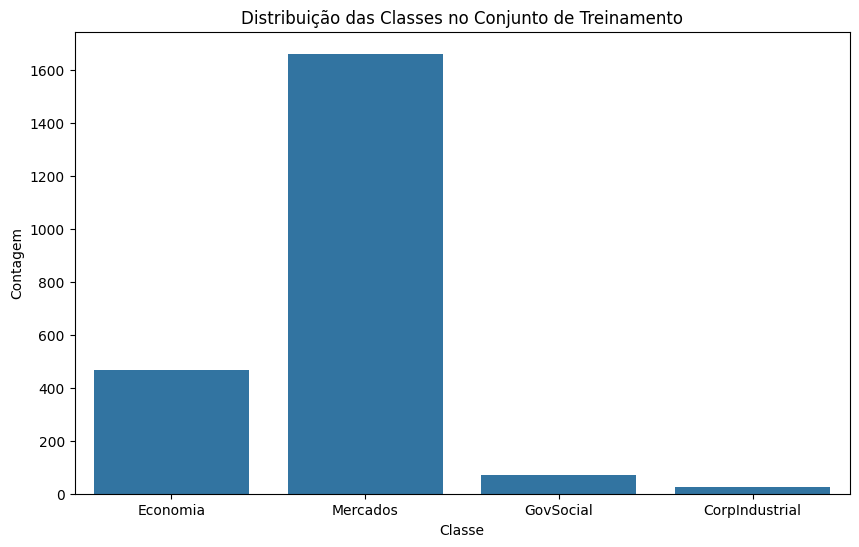

Textos faltantes no conjunto de treinamento: 0
Textos duplicados no conjunto de treinamento: 366
Tamanho médio dos textos: 95.69
Tamanho máximo dos textos: 431
Tamanho mínimo dos textos: 8


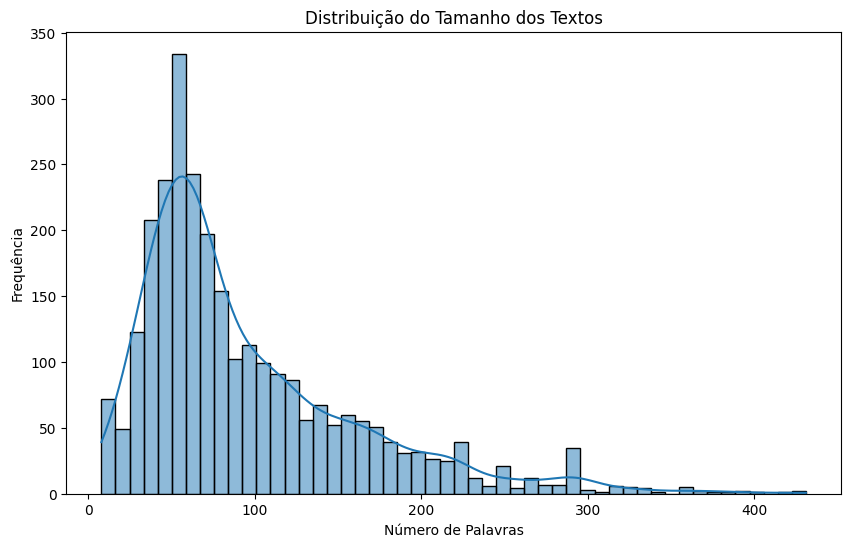

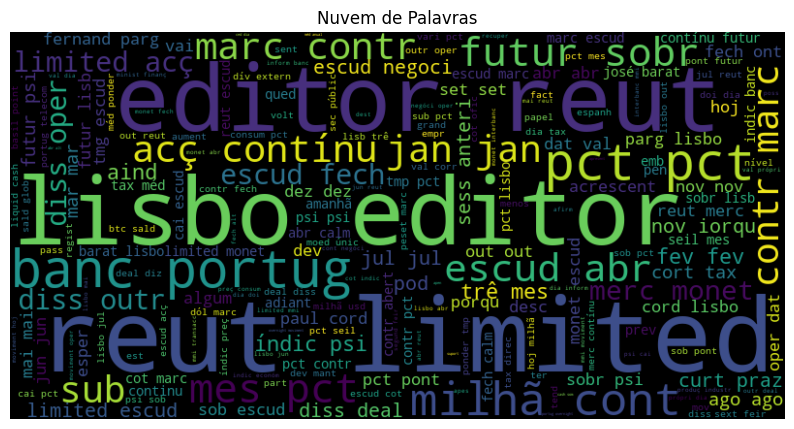

C:\Users\dezin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
C:\Users\dezin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
C:\Users\dezin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for 

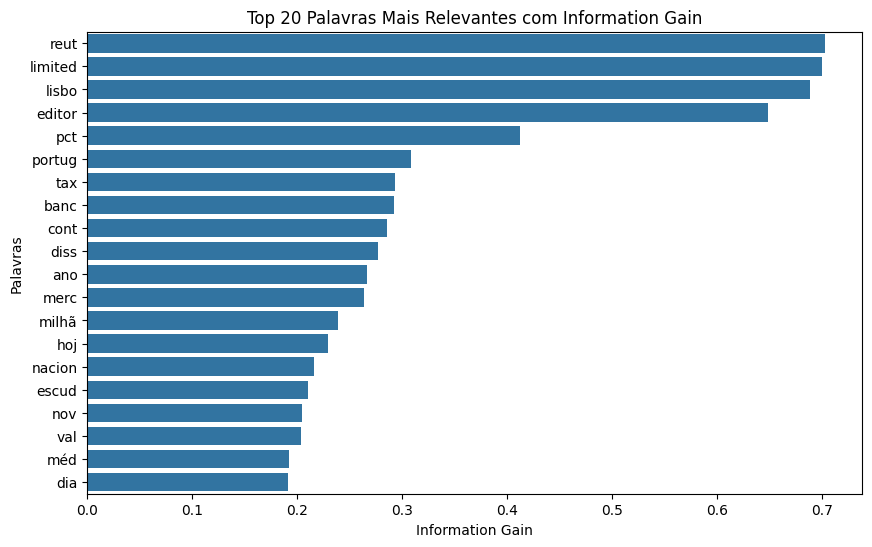

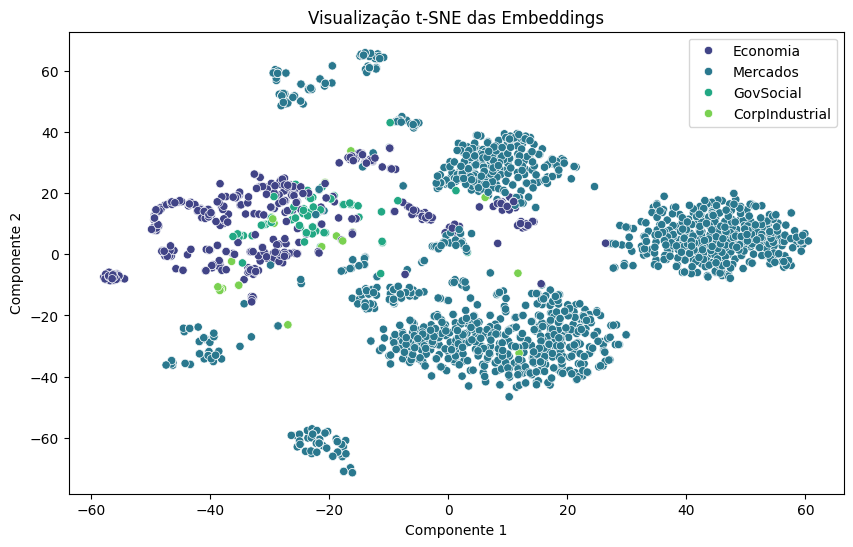

In [5]:
# Exploratory Data Analysis (EDA)

# 1. Dataset Statistics
print(f"Número total de notícias: {len(train_df)}")
print(f"Número de classes: {train_df['Class'].nunique()}")
print(train_df['Class'].value_counts())

# 2. Class Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x=y_train)
plt.title('Distribuição das Classes no Conjunto de Treinamento')
plt.xlabel('Classe')
plt.ylabel('Contagem')
plt.show()

# 3. Check for Missing Texts
missing_texts = sum([1 for text in processed_texts if text == ''])
print(f'Textos faltantes no conjunto de treinamento: {missing_texts}')

# 4. Check for Duplicates
duplicate_texts = len(processed_texts) - len(set(processed_texts))
print(f'Textos duplicados no conjunto de treinamento: {duplicate_texts}')

# 5. Descriptive Statistics of Texts
text_lengths = [len(text.split()) for text in processed_texts if text]
print(f'Tamanho médio dos textos: {sum(text_lengths)/len(text_lengths):.2f}')
print(f'Tamanho máximo dos textos: {max(text_lengths)}')
print(f'Tamanho mínimo dos textos: {min(text_lengths)}')

plt.figure(figsize=(10, 6))
sns.histplot(text_lengths, bins=50, kde=True)
plt.title('Distribuição do Tamanho dos Textos')
plt.xlabel('Número de Palavras')
plt.ylabel('Frequência')
plt.show()

# 6. Word Cloud
all_text = ' '.join(processed_texts)
wordcloud = WordCloud(width=800, height=400, stopwords=stopwords.words('portuguese')).generate(all_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Nuvem de Palavras')
plt.axis('off')
plt.show()

# 7. Top Words by Information Gain
vectorizer = TfidfVectorizer(stop_words=stopwords.words('portuguese'))
X_train_vec = vectorizer.fit_transform(X_train)
info_gain = mutual_info_classif(X_train_vec, y_train, discrete_features=True)

features = vectorizer.get_feature_names_out()
top_features = sorted(zip(info_gain, features), reverse=True)[:20]
scores, terms = zip(*top_features)

plt.figure(figsize=(10, 6))
sns.barplot(x=list(scores), y=list(terms))
plt.title('Top 20 Palavras Mais Relevantes com Information Gain')
plt.xlabel('Information Gain')
plt.ylabel('Palavras')
plt.show()

# 8. t-SNE Visualization of Embeddings
tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(X_train_vec.toarray())

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_train_tsne[:, 0], y=X_train_tsne[:, 1], hue=y_train, palette='viridis')
plt.title('Visualização t-SNE das Embeddings')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.legend()
plt.show()


In [6]:
# Define vectorizers
vectorizers = {
    'TF': CountVectorizer(binary=False, stop_words=stopwords.words('portuguese')),
    'TF-IDF': TfidfVectorizer(stop_words=stopwords.words('portuguese'), ngram_range=(1, 2)),
    'Binary': CountVectorizer(binary=True, stop_words=stopwords.words('portuguese')),
}

# AUC Scorer for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

# F1 Scorer for multi-class
def multiclass_f1_score(y_test, y_pred, average="macro"):
    return f1_score(y_test, y_pred, average=average)

# Store the best pipeline for each vectorizer
pipelines = {}
auc_scores = {}
f1_scores = {}

# Parâmetros adicionais para GridSearchCV
param_grid = {
    'classifier__alpha': [0.001, 0.01, 0.1, 0.5, 1.0],
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'vectorizer__min_df': [1, 5, 10],
    'vectorizer__max_df': [0.8, 0.9, 1.0]
}

# StratifiedKFold para Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Test different vectorizers and hyperparameters
for key, vectorizer in vectorizers.items():
    pipeline = ImbPipeline([
        ('vectorizer', vectorizer),
        ('selector', SelectKBest(chi2, k=1000)),
        ('smote', SMOTE(random_state=42)),
        ('classifier', MultinomialNB())
    ])
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring=make_scorer(multiclass_roc_auc_score))
    grid_search.fit(X_train, y_train)
    pipelines[key] = grid_search.best_estimator_
    auc_scores[key] = multiclass_roc_auc_score(y_test, grid_search.predict(X_test))
    f1_scores[key] = multiclass_f1_score(y_test, grid_search.predict(X_test))
    print(f"AUC para o vetorizador {key} com MultinomialNB: {auc_scores[key]:.2f}")
    print(f"F1 Score para o vetorizador {key} com MultinomialNB: {f1_scores[key]:.2f}")

# Compare the best pipeline from each model
best_key_nb = max(auc_scores, key=auc_scores.get)
best_pipeline_nb = pipelines[best_key_nb]
y_pred_nb = best_pipeline_nb.predict(X_test)
test_auc_nb = auc_scores[best_key_nb]
test_f1_nb = f1_scores[best_key_nb]
print(f"AUC no conjunto de teste para o melhor vetorizador com MultinomialNB ({best_key_nb}): {test_auc_nb:.2f}")
print(f"F1 Score no conjunto de teste para o melhor vetorizador com MultinomialNB ({best_key_nb}): {test_f1_nb:.2f}")

# Melhor método de vetorização
print(f"Melhor método de vetorização: {best_key_nb}")

AUC para o vetorizador TF com MultinomialNB: 0.89
F1 Score para o vetorizador TF com MultinomialNB: 0.80
AUC para o vetorizador TF-IDF com MultinomialNB: 0.92
F1 Score para o vetorizador TF-IDF com MultinomialNB: 0.83
AUC para o vetorizador Binary com MultinomialNB: 0.87
F1 Score para o vetorizador Binary com MultinomialNB: 0.76
AUC no conjunto de teste para o melhor vetorizador com MultinomialNB (TF-IDF): 0.92
F1 Score no conjunto de teste para o melhor vetorizador com MultinomialNB (TF-IDF): 0.83
Melhor método de vetorização: TF-IDF
